# Домашняя работа №8
*Екатерина Драгомирова*

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [51]:
X, y = load_iris(return_X_y=True)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 4), (30, 4))

## Задание 1
### Обучить любую модель классификации на датасете IRIS до применения PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [53]:
# Ошибка
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [54]:
def adaboost(X, y, N, depth):

    n_objects = len(X)
    n_classes = len(np.unique((y)))

    w = np.ones(n_objects) / n_objects

    models = []

    for n in range(N):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)
        
        if error >= 1 - 1/n_classes: 
            continue

        if error == 0:
            error += 1e-10
   
        alpha = 0.5 * np.log((1 - error) / error)

        wrong_mask = predictions != y

        w[wrong_mask] *= np.exp(alpha)
        w[~wrong_mask] *= np.exp(-alpha)

        w /= w.sum()

        models.append((alpha, clf))
    
    return models

In [55]:
def predict(X, models):
    
    n_classes = 3
    n_objects = len(X)
    
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        y_pred[range(n_objects), prediction] += alpha
    
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

### Подбор параметров вручную с помощью визуализации

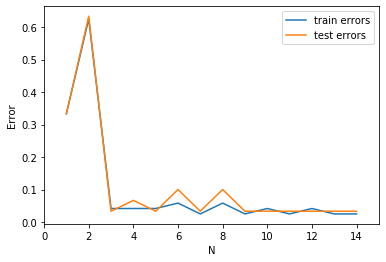

In [56]:
train_errors_trees = []
test_errors_trees = []

for n in range(1, 15):
    depth = 1
    models = adaboost(X_train, y_train, n, depth)
    train_errors_trees.append(get_error(predict(X_train, models), y_train))
    test_errors_trees.append(get_error(predict(X_test, models), y_test))

x = list(range(1, 15))

plt.xlim(0, 15)
plt.plot(x, train_errors_trees, label='train errors')
plt.plot(x, test_errors_trees, label='test errors')
plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

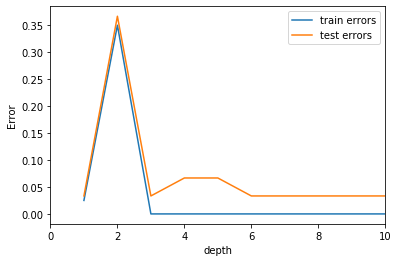

In [57]:
train_errors_depth = []
test_errors_depth = []

for d in range(1, 11):
    N = 50
    models = adaboost(X_train, y_train, N, d)
    train_errors_depth.append(get_error(predict(X_train, models), y_train))
    test_errors_depth.append(get_error(predict(X_test, models), y_test))

x = list(range(1, 11))

plt.xlim(0, 10)
plt.plot(x, train_errors_depth, label='train errors')
plt.plot(x, test_errors_depth, label='test errors')
plt.xlabel('depth')
plt.ylabel('Error')
plt.legend(loc='upper right');

In [67]:
N = 3
depth = 2
models = adaboost(X_train, y_train, N, depth)
error_train = get_error(predict(X_train, models), y_train)
error_test = get_error(predict(X_test, models), y_test)

print(error_train)
print(error_test)

0.03333333333333333
0.03333333333333333


### Обучение / предсказание до PCA

In [68]:
result_models = adaboost(X_train, y_train, 3, 2)
results = predict(X_test, result_models)
result_error = get_error(results, y_test)
print(f'Ошибка при обучении adaboost до PCA: {round(result_error, 3)}')

Ошибка при обучении adaboost до PCA: 0.033


### Реализация PCA

In [69]:
def PCA_for_iris():
    X, y = load_iris(return_X_y=True)
    X = X.astype(float)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    covariance_matrix = X.T @ X
    
    eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])
    
    Z = X.dot(W)
    
    return Z, y

In [70]:
Z, y = PCA_for_iris()
X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

### Обучение / предсказание после PCA

In [71]:
result_models = adaboost(X_train, y_train, 3, 2)
results = predict(X_test, result_models)
result_error = get_error(results, y_test)
print(f'Ошибка при обучении adaboost после PCA: {round(result_error, 3)}')

Ошибка при обучении adaboost после PCA: 0.133
